In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from ISLP import load_data
from ISLP.models import ModelSpec as MS
import sklearn.model_selection as skm
from sklearn.ensemble import RandomForestRegressor as RF

## Random Forests

### Fitting Forests
Here we fit a regression tree to the  `Boston`  data set.

### The Boston Data

A data set containing housing values in 506 suburbs of Boston.
     
- `crim`: per capita crime rate by town.

- `zn`: proportion of residential land zoned for lots over 25,000
sq.ft.

- `indus`: proportion of non-retail business acres per town.

- `chas`: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

- `nox`: nitrogen oxides concentration (parts per 10 million).

- `rm`: average number of rooms per dwelling.

- `age`: proportion of owner-occupied units built prior to 1940.

- `dis`: weighted mean of distances to five Boston employment centres.

- `rad`: index of accessibility to radial highways.

- `tax`: full-value property-tax rate per $10,000.

- `ptratio`: pupil-teacher ratio by town.

- `lstat`: lower status of the population (percent).

- `medv`: median value of owner-occupied homes in $1000s.

This dataset was obtained from, and is slightly modified from, the
Boston dataset that is part of the `R` library `MASS`.  References are
available in the MASS library.

The steps for regression trees are similar to those for classification trees.

In [2]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)


First, we split the data into training and test sets, and fit the tree
to the training data. Here we use 30% of the data for the test set.


In [3]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                Boston['medv'],
                                test_size=0.3,
                                random_state=0)


## Bagging and Random Forests

Here we apply bagging and random forests to the `Boston` data, using
the `RandomForestRegressor()` from the `sklearn.ensemble` package. Recall
that bagging is simply a special case of a random forest with
$m=p$. Therefore, the `RandomForestRegressor()`  function can be used to
perform both bagging and random forests. We start with bagging.

In [4]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train)


RandomForestRegressor(max_features=12, random_state=0)

The argument `max_features` indicates that all 12 predictors should
be considered for each split of the tree --- in other words, that
bagging should be done.  How well does this bagged model perform on
the test set?

14.634700151315787

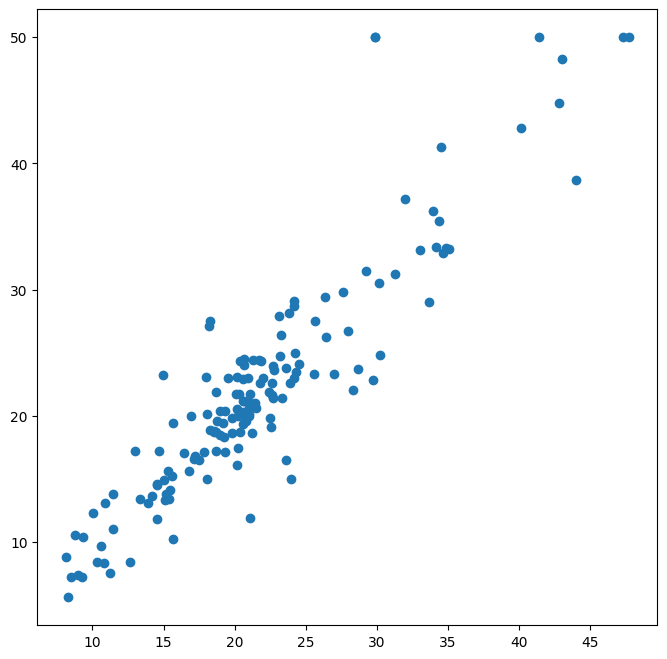

In [5]:
ax = plt.subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)


The test set MSE associated with the bagged regression tree is
14.63. We could change the number of trees grown from the default of
100 by
using the `n_estimators` argument:

In [6]:
bag_boston = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

14.605662565263161

There is not much change. Bagging and random forests cannot overfit by
increasing the number of trees, but can underfit if the number is too small.

Growing a random forest proceeds in exactly the same way, except that
we use a smaller value of the `max_features` argument. By default,
`RandomForestRegressor()`  uses $p$ variables when building a random
forest of regression trees (i.e. it defaults to bagging), and `RandomForestClassifier()` uses
$\sqrt{p}$ variables when building a
random forest of classification trees. Here we use `max_features=6`.

In [7]:
RF_boston = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)


20.04276446710527

The test set MSE is 20.04;
this indicates that random forests did somewhat worse than bagging
in this case. Extracting the `feature_importances_` values from the fitted model, we can view the
importance of each variable.

In [8]:
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


 This
is a relative measure of the total decrease in node impurity that results from
splits over that variable, averaged over all trees

The results indicate that across all of the trees considered in the
random forest, the wealth level of the community (`lstat`) and the
house size (`rm`) are by far the two most important variables.

  

## Causal Forests

In [9]:
url = "https://raw.githubusercontent.com/d2cml-ai/CausalAI-Course/refs/heads/main/Labs/PD/PD10/online_discounts.csv"
df = pd.read_csv(url)
df.head()

,Unnamed: 0,time,device,browser,region,discount,spend
0,0,10.779006,mobile,edge,9,0,0.455164
1,1,0.568973,desktop,firefox,9,0,11.036871
2,2,3.743871,mobile,safari,7,0,1.811193
3,3,13.373436,desktop,other,5,0,31.904944
4,4,0.708575,mobile,explorer,2,1,15.419862


We have data on 100.000 store visitors, for whom we observe the `time` of the day the acessed the website, the `device` they use, their `browser`, and their geographical `region`. We also see whether they were offered the `discount`, our treatment, and what is their `spend`, the outcome of interest. The following code snippet describes how this effect (the value of $Y_i(1)-Y_i(0)$ for each user $i$) is generated.

```python
effect = 7*np.exp(-(df.time-18)**2/100) + 3*(df.browser=='safari') - 2*(df.device=='desktop') + (df.region=='3') - 2.5
```

Since the treatment was randomly assigned, we can use a simple **difference-in-means** estimator to estimate the treatment effect. We expect the treatment and control group to be similar, except for the `discount`, therefore we can causally attribute any difference in `spend` to the `discount`.

In [10]:
import statsmodels.formula.api as smf
smf.ols('spend ~ discount', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.1221,0.045,112.734,0.000,5.033,5.211
discount,1.7507,0.064,27.261,0.000,1.625,1.877


The discount seems to be effective: on average the spend in the treatment group increases by 1.95$. But are all customers equally affected?

To answer this question, we would like to estimate **heterogeneous treatment effects**, possibly at the individual level. 
There are many different options to compute heterogeneous treatment effects. The simplest one is to interact the outcome of interest with a dimension of heterogeneity. The problem with this approach is which variable to pick. Sometimes we have prior information that might guide out actions; for example, we might know that `mobile` users on average spend more than `desktop` users. Other times, we might be interested in one dimension for business reasons; for example we might want to invest more in a certain `region`. However, when we do not extra information we would like this process to be data-driven.

In the previous Lab we have explored one data-driven approach to estimate heterogeneous treatment effects: **causal trees**. We will now expand them to causal forests.
Causal Forests are the equivalent of random forests, but for the estimation of heterogeneous treatment effects, exaxtly as for causal trees and regression trees. Exactly as for Causal Trees, we have a fundamental problem: we are interested in predicting an object that we do not observe: the individua treatment effects $\tau_i$. The solution is to create an auxiliary outcome variable $Y^*$ whose expected value for each single observation is exactly the treatment effect.

$$
Y_i^* = \frac{Y_i}{D_i \cdot p(X_i) - (1-D_i) \cdot (1-p(X_i))}
$$

If you want to know more details on why this variable is unbiased for the individual treatment effect, have a look at my [previous post](https://towardsdatascience.com/920177462149) where I go more in detail. In short, you can interpret $Y_i^*$ as the difference-in-means estimator for a single observation.

Once we have an outcome variable, there are still a couple of things we need to do in order to use Random Forests to estimate heterogeneous treatment effects. First, we need to build trees that have an equal number of treated and control units in each leaf. Second, we need to use different samples to build the tree and evaluate it, i.e. compute the average outcome per leaf. This procedure is often referred to as **honest trees** and it's extremely helpful for inference, since we can treat the sample of each leaf as independent from the tree structure. 

Before we go into the estimation, let's first generate dummy variables for our categorical variables, `device`, `browser` and `region`.

In [11]:
df['region']= df['region'].astype(str)

df_dummies = pd.get_dummies(df[['device','browser','region']], drop_first=True)
df = pd.concat([df, df_dummies], axis=1)
X = ['time'] + list(df_dummies.columns)

We can now estimate the heterogeneous treatment effects using the Random Forest algorithm. Luckily, we don't have to do all this by hand, but there is a great implementation of Causal Trees and Forests in Microsoft's [EconML](https://econml.azurewebsites.net/) package. We will use the `CausalForestDML` function. We set a seed for reproducibility.

In [12]:
from econml.dml import CausalForestDML

np.random.seed(0)
forest_model = CausalForestDML(max_depth=3)
forest_model = forest_model.fit(Y=df["spend"], X=df[X], T=df["discount"])

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Differently from Causal Trees, Causal Forests are harder to interpret since we cannot visualize every single tree. We can use the `SingleTreeCateInterpreter` function to plot an equivalent representation of the Causal Forest algorithm.

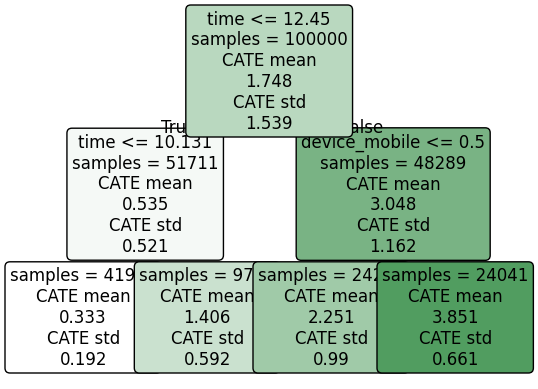

In [13]:
from econml.cate_interpreter import SingleTreeCateInterpreter
%matplotlib inline

intrp = SingleTreeCateInterpreter(max_depth=2).interpret(forest_model, df[X])
intrp.plot(feature_names=X, fontsize=12)

We can interpret the tree diagram exactly as for the Causal Tree model. On the top, we can see the average $Y^*$ in the data, $1.917$. Starting from there, the data gets split into different branches, according to the rules highlighted at the top of each node. For example, the first node splits the data into two groups of size $46878$ and $53122$ depending on whether the `time` is later than $11.295$. At the bottom, we have our final partitions, with the predicted values. For example, the leftmost leaf contains $40191$ observation with `time` earlier than $11.295$ and non-Safari `browser`, for which we predict a spend of $0.264$. Darker node colors indicate higher prediction values.

The problem with this representation is that, differently from the case of Causal Trees, it is only an interpretation of the model. Since Causal Forests are made of many bootstrapped trees, there is no way to directly inspect each decision tree. One way to understand which feature is most important in detemining the tree split is the so-called [feature importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

In [14]:
pd.DataFrame({"variable": X, "importance": forest_model.feature_importances()})

,variable,importance
0,time,0.906628
1,device_mobile,0.042254
2,browser_chrome,0.000082
3,browser_edge,0.000184
4,browser_explorer,0.000109
5,browser_firefox,0.000006
6,browser_other,0.000003
7,browser_safari,0.050264
8,region_1,0.000062
9,region_2,0.000032


set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


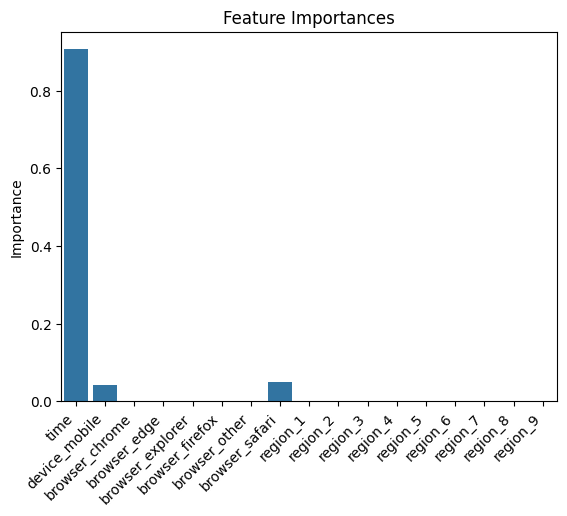

In [15]:
fig, ax = plt.subplots()
sns.barplot(x=X, y=forest_model.feature_importances(), color='C0').set(
    title='Feature Importances', ylabel='Importance')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

Clearly `time` is the first dimension of heterogeneity, followed by `device` (mobile in particular) and `browser` (safari in particular). Other dimensions do not matter much.

We can now do a more relevant test: how well the algorithm performs with a continuous variable such as `time`? First, let’s again isolate the predicted treatment effects on `time` and ignore the other covariates.

In [16]:
df["effect"] = 7*np.exp(-(df.time-18)**2/100) + 3*(df.browser=='safari') - 2*(df.device=='desktop') + (df.region=='3') - 2.5
df.loc[df.effect < 0, "effect"] = 0

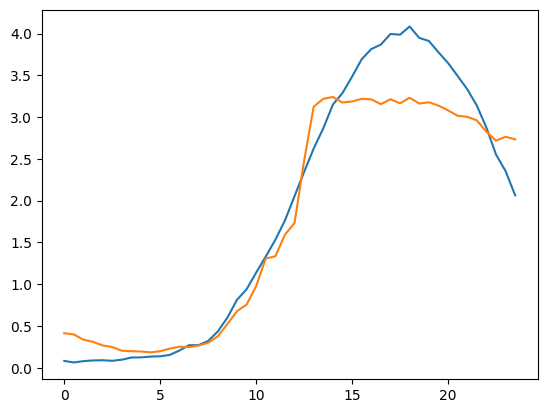

In [17]:
df["time_bins"] = (df["time"] * 2).astype(int) / 2
effect_bins = df.groupby("time_bins")["effect"].mean()
df["predicted_effect"] = forest_model.effect(df[X])
predicted_effect_bins = df.groupby("time_bins")["predicted_effect"].mean()
plt.plot(effect_bins.index, effect_bins.values)
plt.plot(predicted_effect_bins.index, predicted_effect_bins.values)